All Packages I might need

In [1]:
import numpy as np
from numpy.random import randn

import pandas as pd
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
from matplotlib import rcParams

from pylab import rcParams

import seaborn as sb

import math as m

import time as t

In [2]:
EPL=pd.read_csv('EPL_Scores_Clean.csv')
EPL=EPL.drop(['FTR','HTHG','HTAG','HTR'],axis=1)
EPL_DF=pd.DataFrame(EPL)

In [3]:
def Result(F,A):
    if F==A:
        return 1/3
    elif F>A:
        return 1
    else:
        return 0

In [4]:
EPL_DF_Home=EPL_DF.drop('AwayTeam',axis=1)
EPL_DF_Home=EPL_DF_Home.rename(columns={'HomeTeam':'Team','FTHG':'HomeFor','FTAG':'HomeAgainst'})
EPL_DF_Home['AwayFor']=np.NaN #empty road columns
EPL_DF_Home['AwayAgainst']=np.NaN
EPL_DF_Home['For']=EPL_DF_Home['HomeFor']
EPL_DF_Home['Against']=EPL_DF_Home['HomeAgainst']
EPL_DF_Home['HomeResult'] = EPL_DF_Home.apply(lambda row: Result(row['HomeFor'],row['HomeAgainst']),axis=1)
EPL_DF_Home['AwayResult']=np.NaN
EPL_DF_Home['Result']=EPL_DF_Home['HomeResult'] #result regardless of location (sum to see winner of league)

EPL_DF_Away=EPL_DF.drop('HomeTeam',axis=1)
EPL_DF_Away=EPL_DF_Away.rename(columns={'AwayTeam':'Team','FTHG':'AwayAgainst','FTAG':'AwayFor'})
EPL_DF_Away['HomeFor']=np.NaN #empty road columns
EPL_DF_Away['HomeAgainst']=np.NaN
EPL_DF_Away['For']=EPL_DF_Away['AwayFor']
EPL_DF_Away['Against']=EPL_DF_Away['AwayAgainst']
EPL_DF_Away['AwayResult'] = EPL_DF_Away.apply(lambda row: Result(row['AwayFor'],row['AwayAgainst']),axis=1)
EPL_DF_Away['HomeResult']=np.NaN
EPL_DF_Away['Result']=EPL_DF_Away['AwayResult']

EPL_DF_All=EPL_DF_Home.append(EPL_DF_Away,ignore_index=True)

In [5]:
#How frequent are ties?
EPL_DF_All[EPL_DF_All['Result']==1/3].Result.count(), EPL_DF_All['Result'].count()

(1880, 7600)

In [6]:
EPL_Results=EPL_DF_All.groupby(['Season','Team']).sum()


In [7]:
EPL_DF=EPL_DF_All.groupby(['Season','Team']).mean()
#EPL_Final.to_csv(r'EPL_Final_Results.csv',index=True,header=True)

Pythagorean calculation doesn't work for EPL since ties award less total points. Use a simulation instead

In [8]:
def PoissonSim(l,r):
    t=0
    k=0
    while t<r:
        t=t+((np.e**(-l))*(l**k))/m.factorial(k)
        k=k+1
    return k-1

In [9]:
PoiDF=pd.DataFrame(np.random.rand(190),columns=['s']) #Data Frame of 1000 randoms(0,1)
l=2.16 #Lambda example
PoiDF['s'] = PoiDF.apply(lambda row: PoissonSim(l,row[0]),axis=1) #overwrite each random with sim

array([[<AxesSubplot:title={'center':'s'}>]], dtype=object)

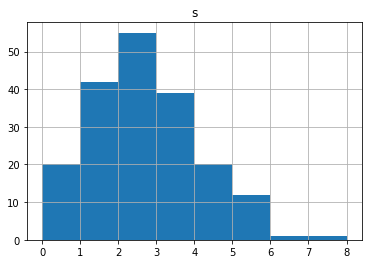

In [10]:
PoiDF.hist(bins=range(0,PoiDF.s.max()+2))

In [11]:
max_test=4.1 #highest goals for to look at
min_test=.1
sims=10000 #num of sims per pair
step=.1 #Step size
steps=m.ceil((max_test-min_test)/step) # number of steps
Sim_Array=np.zeros((steps,steps)) #Initialize empty results array
l1_Array=np.arange(min_test,max_test,step) #Like Range, but makes array object
l2_Array=np.arange(min_test,max_test,step)
i=0
j=0

for f in l1_Array:
    j=0
    for a in l2_Array:
        PoiDF=pd.DataFrame(np.random.rand(10000).reshape(5000,2),columns=['f','a']) #random array
        PoiDF['s'] = PoiDF.apply(lambda row: Result(PoissonSim(f,row['f']),PoissonSim(a,row['a'])),axis=1) #new column with simulated result
        Sim_Array[i,j]=PoiDF.s.mean() #mean into results array
        j=j+1
    i=i+1
        
df_final=pd.DataFrame(Sim_Array,columns=l2_Array,index=l1_Array) #save as dataframe with values of l1 and l2 as labels


In [13]:
df_final.to_csv(r'EPL_Simulation.csv',index=True,header=True)

Single-use commands

In [14]:
p_EPL=1.25

EPL_DF.reset_index(level=0, inplace=True)

EPL_Matrix=pd.read_csv('EPL_Simulation.csv',index_col=0)
EPL_Matrix=pd.DataFrame(EPL_Matrix)

def EPL_Expected(F,A):
    min_test=.1                             #minimum in table
    step=.1                                 #Step size
    r_1=m.floor((F-min_test)/step)          #lower row of table
    c_1=m.floor((A-min_test)/step)          #lower col of table
    r_2=r_1+1                               #Upper row of table
    c_2=c_1+1                               #lower col of table
    a=EPL_Matrix.iloc[r_1,c_1]              #upper left
    b=EPL_Matrix.iloc[r_1,c_2]              #upper right
    c=EPL_Matrix.iloc[r_2,c_1]              #lower left
    d=EPL_Matrix.iloc[r_2,c_2]              #lower right
    r_r=m.modf((F-min_test)/step)[0]        #mod F returns [frac,int] so just want frac component
    c_r=m.modf((A-min_test)/step)[0]

    if r_r<.5 and c_r<.5:                   #point in upper left
        res=a+(c-a)*r_r+(b-a)*c_r
    elif r_r<.5 and c_r>=.5:                #point in upper right
        res=b+(c-a)*r_r-(b-a)*(1-c_r)
    elif r_r>=.5 and c_r<.5:                #point in lower left
        res=c-(c-a)*(1-r_r)+(b-a)*c_r
    else:                                   #point in lower right
        res=d-(c-a)*(1-r_r)-(b-a)*(1-c_r)

    return res

EPL_DF['PythagHome']= EPL_DF.apply(lambda row: EPL_Expected(row['HomeFor'],row['HomeAgainst']),axis=1)
EPL_DF['PythagAway']= EPL_DF.apply(lambda row: EPL_Expected(row['AwayFor'],row['AwayAgainst']),axis=1)
EPL_DF['Pythag']= EPL_DF.apply(lambda row: EPL_Expected(row['For'],row['Against']),axis=1)
EPL_DF['SeasRank'] = EPL_DF.groupby(['Season'])['Pythag'].rank(method='first', ascending=False)
    
def PoissonSim(l,r): #l=average #r is random value
    t=0
    k=0
    while t<r:
        t=t+((np.e**(-l))*(l**k))/m.factorial(k)
        k=k+1
    return k-1

Avg_HF=EPL_DF.HomeFor.mean()
Avg_HA=EPL_DF.HomeAgainst.mean()

def FullGameSim(HF,HA,AF,AA,Avg_HF,Avg_HA):
    r1=np.random.rand()
    r2=np.random.rand()
    HF_Sim=PoissonSim((HF*AA)/Avg_HF,r1)
    AF_Sim=PoissonSim((AF*HA)/Avg_HA,r2)
    return Result(HF_Sim,AF_Sim),Result(AF_Sim,HF_Sim),HF_Sim,AF_Sim

EPL_Averages=pd.DataFrame(pd.read_csv('EPl_Averages.csv'))

All iterative commands

In [15]:
t_start=t.time()
Num_Seasons=10
Results=[]

EPL_Sched=pd.DataFrame(pd.read_excel('EPL_Schedule.xlsx'))

EPL_Sched[['HomeResult','AwayResult','HomeFor','AwayFor']]=np.NAN
game=[]

for s in range(0,Num_Seasons):
    for i in range(0,EPL_Sched.shape[0]): 
        game=FullGameSim(EPL_Averages.iloc[EPL_Sched.iloc[i,0]-1,2]
                         ,EPL_Averages.iloc[EPL_Sched.iloc[i,0]-1,3]
                         ,EPL_Averages.iloc[EPL_Sched.iloc[i,1]-1,4]
                         ,EPL_Averages.iloc[EPL_Sched.iloc[i,1]-1,5]
                         ,Avg_HF,Avg_HA)
        EPL_Sched.loc[i,'HomeResult':'AwayFor']=game

    EPL_Standings=pd.DataFrame({'Team': range(1,21),'Result':np.zeros(20),'For':np.zeros(20),'Against':np.zeros(20)})
    for i in range(1,21):
        EPL_Standings.iloc[i-1,1]=(EPL_Sched.groupby('Home').mean().HomeResult[i]+
                                   EPL_Sched.groupby('Away').mean().AwayResult[i])/2
        EPL_Standings.iloc[i-1,2]=(EPL_Sched.groupby('Home').sum().HomeFor[i]+
                                   EPL_Sched.groupby('Away').sum().AwayFor[i])
        EPL_Standings.iloc[i-1,3]=(EPL_Sched.groupby('Home').sum().AwayFor[i]+
                                   EPL_Sched.groupby('Away').sum().HomeFor[i])

    EPL_Standings['Rank']=EPL_Standings.Result.rank(method='first', ascending=False) #Assign rank to each team
    EPL_Standings['Sim']=s #Add simulation number to each table
    
    #Append the results array
    if s==0:
        Results=EPL_Standings
    else:
        Results=Results.append(EPL_Standings)
    
t_total=t.time()-t_start
t_total

5.514883756637573

<AxesSubplot:>

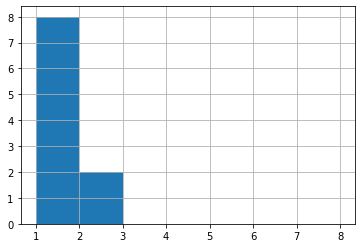

In [17]:
Results.loc[Results.Rank==1].Team.hist(bins=range(1,9),xlabelsize=10)

In [ ]:
#Results.to_csv('EPL_Simulation_Results.csv')